In [2]:
%matplotlib notebook
from matplotlib import animation, rc
from IPython.display import HTML
import ffmpeg
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg.dsolve import spsolve
import matplotlib.animation as animation

3.866863471612396
La vitesse de propagation de la simulation est s= 1.4589178356713421
La vitesse théorique de propagation est s_theorique= 1.469693845669907


<IPython.core.display.Javascript object>


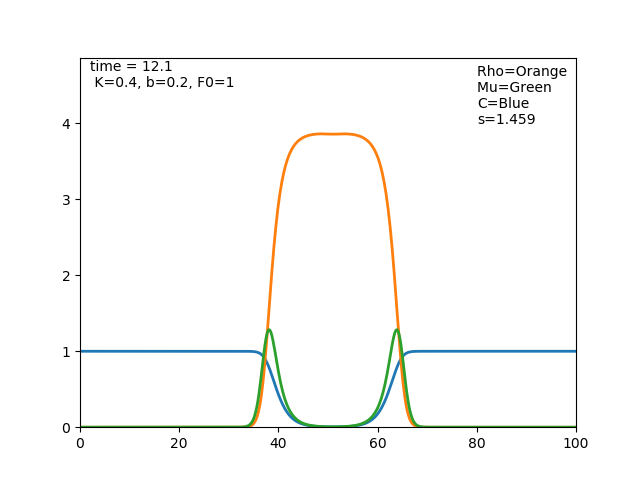

In [65]:
# %load edp_1d.py
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg.dsolve import spsolve
import matplotlib.animation as animation

#Coéfficients physiques
K=.4 #coefficient diffusion
b=.2 # dtC=-b*rho*C
F0=1 # dtRho = Fo*Mu

#Paramêtres numériques 
n_t=5001 #nombre de pas de temps
tf=25 # temps final de la simulation
xf = 100 #longeur de la simulation
n_x =500 #nombres de points de la simulation

#Données initiales 
rho0=np.zeros(n_x) #rho initial	
mu0=np.zeros(n_x) #mu initial
mu0[(n_x//2):(n_x//2 +10)]=.01
c0=np.zeros(n_x)+1 #concentration initiale

def edp_1d_explicite(K, b, F0, rho0, mu0, c0, n_t , tf, xf, n_x):
	dt=tf/(n_t-1)
	dx=xf/(n_x-1)
	X=np.linspace(0,xf,n_x)
	T=np.linspace(0,tf,n_t)
	Mu=np.zeros((n_t,n_x))
	Rho=np.zeros((n_t,n_x))
	C=np.zeros((n_t,n_x))
	Mu[0]=mu0
	Rho[0]=rho0
	C[0]=c0
	#Résolution	du schema éxplicite
	for n in range(0,n_t-1):
		RHS=np.zeros(n_x)
		alpha=-C[n]*dt*(1+dt*F0)+dt*Rho[n]+1
		RHS[1:-1]= dt*((K/(dx**2))*(Mu[n,:-2]-2*Mu[n,1:-1]+Mu[n,2:])+C[n,1:-1]*Rho[n,1:-1])
		RHS[0]= dt*((K/(dx**2))*(-2*Mu[n,0]+Mu[n,1])+C[n,0]*Rho[n,0])
		RHS[-1]=dt*((K/(dx**2))*(-2*Mu[n,-1]+Mu[n,-2])+C[n,-1]*Rho[n,-1])
		Mu[n+1]=(1/alpha)*(Mu[n]+RHS)
		Rho[n+1]=Rho[n]+dt*F0*Mu[n+1]
		C[n+1]=C[n]/(1 + b*dt*Rho[n])
	return X,T,Mu,Rho,C

def edp_1d_semi_implicite_I(K, b, F0, rho0, mu0, c0, n_t , tf, xf, n_x):
	#Détermination des paramêtres numeriques deltat et deltax
	dt=tf/(n_t-1)
	dx=xf/(n_x-1)
	#Représentation de l'éspace et du temps
	X=np.linspace(0,xf,n_x)
	T=np.linspace(0,tf,n_t)
	#Initialisation
	Mu=np.zeros((n_t,n_x))
	Rho=np.zeros((n_t,n_x))
	C=np.zeros((n_t,n_x))
	Mu[0]=mu0
	Rho[0]=rho0
	C[0]=c0
	#Résolution	du schéma implicite-explicite I
	for n in range(0,n_t-1):
		alpha=-C[n]*dt*(1+dt*F0)+dt*Rho[n]+1
		A=np.diag(-np.ones(n_x-1),-1)+np.diag(2*np.ones(n_x),0)+np.diag(-np.ones(n_x-1),1)
		A=A*K*dt/(dx**2)
		A+=np.diag(alpha,0)
		Mu[n+1]= spsolve(A, Mu[n]+dt*C[n]*Rho[n])
		Rho[n+1]=Rho[n]+dt*F0*Mu[n+1]
		C[n+1]=C[n]/(1 + b*dt*Rho[n])
	return X,T,Mu,Rho,C

def edp_1d_semi_implicite_II(K, b, F0, rho0, mu0, c0, n_t , tf, xf, n_x):
	#Détermination des paramêtres numériques deltat et deltax
	dt=tf/(n_t-1)
	dx=xf/(n_x-1)
	#Représentation de l'éspace et du temps
	X=np.linspace(0,xf,n_x)
	T=np.linspace(0,tf,n_t)
	#Initialisation
	Mu=np.zeros((n_t,n_x))
	Rho=np.zeros((n_t,n_x))
	C=np.zeros((n_t,n_x))
	Mu[0]=mu0
	Rho[0]=rho0
	C[0]=c0
	#Résolution	du schéma implicite-explicite II
	for n in range(0,n_t-1):
		#Matrice du Laplacien
		A=np.diag(-np.ones(n_x-1),-1)+np.diag(2*np.ones(n_x),0)+np.diag(-np.ones(n_x-1),1)		
		A=A*K*dt/(dx**2) #Laplacien Numerique
		#Ajout des termes implicites
		alpha=-C[n]*dt*(1+dt*F0)+1
		A+=np.diag(alpha,0)
		A= csc_matrix(A)
        #Résolution du systême implicite
		Mu[n+1]= spsolve(A, Mu[n]+dt*C[n]*Rho[n]-dt*Mu[n]*Rho[n])
		Rho[n+1]=Rho[n]+dt*F0*Mu[n+1]
		C[n+1]=C[n]/(1 + b*dt*Rho[n])
	return X,T,Mu,Rho,C
		
X,T,Mu,Rho,C= edp_1d_semi_implicite_I(K, b, F0, rho0, mu0, c0, n_t , tf, xf, n_x)

#Valeur de rho a l'infini
rho_inf = Rho[n_t-1,(n_x//2)]
print(rho_inf)


def speed(X,Rho):
    #Position du front
	argmed=np.zeros(n_t)
	for i in range(n_t):
		argmed[i]= X[(n_x//2)+np.min(np.where(np.append(Rho[i,(n_x//2):],[0])<rho_inf/2))]
	#Vitesse du front
	S = (argmed[(n_t//2)+1:]-argmed[(n_t//2):-1])*((n_t-1)/tf)
	s= np.average(S)
	return s
s=0
s = speed(X,Rho)
print('La vitesse de propagation de la simulation est s=',s)
s_theorique = np.sqrt(K*((18*F0+4)+np.sqrt(((18*F0+4)**2)+108*(1+4*F0)*(F0**2)))/(2*(1+4*F0)))
#Attention, ceci est pour C0=1
print('La vitesse théorique de propagation est s_theorique=', s_theorique)

#Animation
fig = plt.figure()

ax = plt.axes(xlim=(0, xf), ylim=(0, rho_inf+1))
line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
line4, = ax.plot([], [], lw=2)
time_text = ax.text(0.02, 0.92, '', transform=ax.transAxes)
legend_text = ax.text(0.80, 0.82, '', transform=ax.transAxes)

def init():
    line.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    time_text.set_text('')
    legend_text.set_text('')
    return line,line2,line3,line4, time_text, legend_text


def animate(i):
    line.set_data(X, C[i])
    line2.set_data(X, Rho[i])
    line3.set_data(X, Mu[i])
    #line4.set_data(50+((i*s)*tf/(n_t-1)),np.linspace(0,rho_inf+1,10))
    time_text.set_text('time = {0:.1f}\n K={1}, b={2}, F0={3} '.format(T[i],K,b,F0))
    legend_text.set_text('Rho=Orange \nMu=Green \nC=Blue\ns={0:.3f}'.format(s))
    return line,line2, line3,line4, time_text, legend_text


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=(n_t-1), interval=(tf*200)/(n_t-1), blit=True)
                               


#anim.save('EDP_1D.gif',writer='imagemagick', fps=30)
plt.show()


In [17]:
Rho

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.98331214e-06, 2.99042179e-06, 2.99680462e-06, ...,
        3.11887405e-06, 3.11223123e-06, 3.10483199e-06],
       [7.22388866e-06, 7.23503411e-06, 7.24438404e-06, ...,
        7.44176553e-06, 7.43224285e-06, 7.42087520e-06],
       ...,
       [3.89536155e+00, 3.89679141e+00, 3.89727004e+00, ...,
        3.89727027e+00, 3.89679163e+00, 3.89536177e+00],
       [3.89536155e+00, 3.89679141e+00, 3.89727004e+00, ...,
        3.89727027e+00, 3.89679163e+00, 3.89536177e+00],
       [3.89536155e+00, 3.89679141e+00, 3.89727004e+00, ...,
        3.89727027e+00, 3.89679163e+00, 3.89536177e+00]])

In [4]:
np.sqrt(3*K)

0.7745966692414834

In [5]:
s_theorique = np.sqrt(K*((18*F0+4)+np.sqrt(((18*F0+4)**2)+108*(1+4*F0)*(F0**2)))/(2*(1+4*F0)))
#Attention, ceci est pour C0=1

In [6]:
s_theorique

1.0392304845413265

In [7]:
print(matplotlib.animation.writers.list())

['imagemagick', 'imagemagick_file', 'html']


In [41]:
dt=tf/(n_t-1)
dx=xf/(n_x-1)
#Représentation de l'éspace et du temps
X=np.linspace(0,xf,n_x)
T=np.linspace(0,tf,n_t)
#Initialisation
Mu=np.zeros((n_t,n_x))
Rho=np.zeros((n_t,n_x))
C=np.zeros((n_t,n_x))
Mu[0]=mu0
Rho[0]=rho0
C[0]=c0
A = np.diag(-np.ones(n_x-1),-1)+np.diag(2*np.ones(n_x),0)+np.diag(-np.ones(n_x-1),1)
invA = np.linalg.inv(A) 
#Résolution	du schéma implicite-explicite I
for n in range(0,n_t-1):
    alpha=-C[n]*dt*(1+dt*F0)+dt*Rho[n]+1
    coeff= K*dt/(dx**2)
    aide1= np.dot(invA,Mu[n]+dt*Rho[n]*C[n])
    aide2=(np.dot(invA,alpha)+coeff)
    Mu[n+1]=aide1/aide2
    Rho[n+1]=Rho[n]+dt*F0*Mu[n+1]
    C[n+1]=C[n]/(1 + b*dt*Rho[n])

In [47]:
x = np.array([3,1,2])

In [49]:
x*x

array([9, 1, 4])

In [52]:
np.dot(invA,alpha)+coeff

array([  264.8049347 ,   528.36468822,   790.86598988,  1052.30883248,
        1312.69321243,  1572.01912755,  1830.2865764 ,  2087.49555793,
        2343.64607136,  2598.73811608,  2852.77169159,  3105.74679749,
        3357.66343345,  3608.52159918,  3858.32129444,  4107.062519  ,
        4354.74527268,  4601.36955532,  4846.93536676,  5091.44270688,
        5334.89157555,  5577.28197266,  5818.61389812,  6058.88735183,
        6298.10233371,  6536.25884368,  6773.35688168,  7009.39644762,
        7244.37754146,  7478.30016313,  7711.16431258,  7942.96998976,
        8173.71719463,  8403.40592712,  8632.03618722,  8859.60797486,
        9086.12129002,  9311.57613266,  9535.97250275,  9759.31040025,
        9981.58982513, 10202.81077736, 10422.97325692, 10642.07726377,
       10860.12279789, 11077.10985926, 11293.03844785, 11507.90856364,
       11721.72020661, 11934.47337674, 12146.168074  , 12356.80429838,
       12566.38204986, 12774.90132841, 12982.36213403, 13188.7644667 ,
      

In [3]:
memory = np.loadtxt('memory_data.dat')

In [15]:
K = []
for i in range(25):
    K+=[memory[4*i]]
    
b = []
for i in range(25):
    b+=[memory[4*i+1]]
    
s = []
for i in range(25):
    s+=[memory[4*i+2]]
    
s_theorique =[]
for i in range(25):
    s_theorique+= [memory[4*i+3]]

In [68]:
memory2 = np.loadtxt('memory_data2.dat')

In [69]:
K2 = []
for i in range(25):
    K2+=[memory2[4*i]]
    
b2 = []
for i in range(25):
    b2+=[memory2[4*i+1]]
    
s2 = []
for i in range(25):
    s2+=[memory2[4*i+2]]
    
s_theorique2 =[]
for i in range(25):
    s_theorique2 += [memory2[4*i+3]]

In [75]:
memory3 = np.loadtxt('memory_data3.dat')

In [76]:
K3 = []
for i in range(25):
    K2+=[memory3[4*i]]
    
b3 = []
for i in range(25):
    b2+=[memory3[4*i+1]]
    
s3 = []
for i in range(25):
    s2+=[memory3[4*i+2]]
    
s_theorique3 =[]
for i in range(25):
    s_theorique2 += [memory3[4*i+3]]

<IPython.core.display.Javascript object>


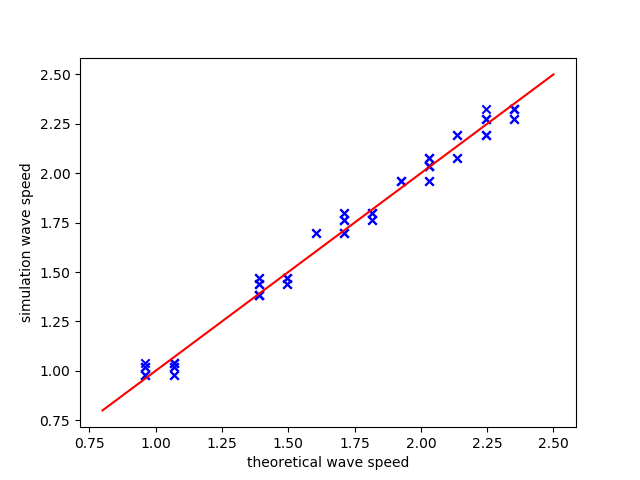

In [77]:

fig = plt.figure()
plt.scatter(s, s_theorique, marker='x', c='b')
plt.scatter(s2, s_theorique2, marker='x', c='b')
plt.scatter(s3, s_theorique3, marker='x', c='b')
plt.ylabel('simulation wave speed')
plt.xlabel('theoretical wave speed')
plt.plot([.8,2.5],[.8,2.5], c='r')
plt.show()

In [25]:
s

[1.0688042752170985,
 1.0688042752171023,
 1.0688042752170985,
 1.0688042752170985,
 0.9619238476953911,
 1.3894455577822327,
 1.3894455577822327,
 1.4963259853039441,
 1.4963259853039441,
 1.4963259853039441,
 1.7100868403473592,
 1.8169672678690707,
 1.7100868403473592,
 1.8169672678690707,
 1.8169672678690707,
 2.1376085504342046,
 2.1376085504342046,
 2.0307281229124934,
 2.0307281229124934,
 2.030728122912486,
 2.2444889779559163,
 2.35136940547762,
 2.3513694054776275,
 2.35136940547762,
 2.35136940547762]

In [67]:
s2

[1.0688042752170985,
 1.0688042752171023,
 1.0688042752170985,
 1.0688042752170985,
 0.9619238476953911,
 1.3894455577822327,
 1.3894455577822327,
 1.4963259853039441,
 1.4963259853039441,
 1.4963259853039441,
 1.7100868403473592,
 1.8169672678690707,
 1.7100868403473592,
 1.8169672678690707,
 1.8169672678690707,
 2.1376085504342046,
 2.1376085504342046,
 2.0307281229124934,
 2.0307281229124934,
 2.030728122912486,
 2.2444889779559163,
 2.35136940547762,
 2.3513694054776275,
 2.35136940547762,
 2.35136940547762]